In [1]:
import QuantumRingsLib
from QuantumRingsLib import QuantumRegister, AncillaRegister, ClassicalRegister, QuantumCircuit
from QuantumRingsLib import QuantumRingsProvider
from QuantumRingsLib import job_monitor
from QuantumRingsLib import JobStatus
from matplotlib import pyplot as plt
import numpy as np
import math
from math import gcd
import random

provider = QuantumRingsProvider(token ='rings-200.VMGQpDL5KTkSA03lEfGTVAOIsvZvZtgw', name='dnagulapati@ucdavis.edu')
backend = provider.get_backend("scarlet_quantum_rings")
shots = 1024
    
provider.active_account()

{'name': 'dnagulapati@ucdavis.edu',
 'token': 'rings-200.VMGQpDL5KTkSA03lEfGTVAOIsvZvZtgw',
 'max_qubits': '200'}

In [2]:
def iqft_cct(qc, b, n):
    """
    The inverse QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        n (int):
                The number of qubits in the registers to use

    Returns:
        None

    """

    for i in range (n):
        for j in range (1, i+1):
            # for inverse transform, we have to use negative angles
            qc.cu1(  -math.pi / 2** ( i -j + 1 ), b[j - 1], b[i])
        # the H transform should be done after the rotations
        qc.h(b[i])
    #qc.barrier()
    return

def qft_cct(qc, b, n):
    """
    The Forward QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        n (int):
                The number of qubits in the registers to use

    Returns:
        None

    """

    while (n):
        qc.h(b[n-1])
        for i in range (n-1, 0, -1):
            qc.cu1(math.pi / 2** (n - i ), b[i - 1], b[n-1])
        n -= 1
        #qc.barrier()
    return

In [3]:
def plot_histogram (counts, title=""):
    """
    Plots the histogram of the counts

    Args:

        counts (dict):
            The dictionary containing the counts of states

        titles (str):
            A title for the graph.

    Returns:
        None

    """
    fig, ax = plt.subplots(figsize =(10, 7))
    plt.xlabel("States")
    plt.ylabel("Counts")
    mylist = [key for key, val in counts.items() for _ in range(val)]

    unique, inverse = np.unique(mylist, return_inverse=True)
    bin_counts = np.bincount(inverse)

    plt.bar(unique, bin_counts)

    maxFreq = max(counts.values())
    plt.ylim(ymax=np.ceil(maxFreq / 10) * 10 if maxFreq % 10 else maxFreq + 10)
    # Show plot
    plt.title(title)
    plt.show()
    return

In [4]:
def modular_exponentiation(qc, a, N, exponent_qubits, result_qubits):

    n = len(exponent_qubits)
    
    # Initialize |1⟩ in result register (since a^0 mod N = 1)
    qc.x(n)

    # Apply modular exponentiation using controlled multiplications
    for i in range(n):  
        exp = 2 ** i
        a_exp = (a ** exp) % N  # Compute (a^exp mod N)
        
        # Apply controlled multiplication with modular addition
        iqft_cct(qc,result_qubits,len(result_qubits))  # QFT Inverse
        for j in range(len(result_qubits)):
            if (a_exp >> j) & 1:  # Apply CNOT for bit-wise controlled addition
                qc.cx(exponent_qubits[i],result_qubits[n-1-j])
        qft_cct(qc,result_qubits,len(result_qubits))  # QFT
        
    return qc

In [5]:
def shors_algorithm(N,a):
    """
    Full implementation of Shor's algorithm for factoring an integer N.
    """
    # Step 2: Compute GCD (if it's a factor, return it)
    if gcd(a, N) > 1:
        return f"Factor found classically: {gcd(a, N)}"
    
    # Step 3: Prepare quantum registers
    n = int(np.ceil(np.log2(N)))  # Number of qubits needed

    exponent_qubits = QuantumRegister(n , 'q')
    result_qubits = QuantumRegister(n , 'r')
    classical_qubits = ClassicalRegister(n , 'c')
    qc = QuantumCircuit(exponent_qubits, result_qubits, classical_qubits)

    # Apply Hadamards to exponent qubits
    for qi in range(n):
        qc.h(qi)
    
    # Perform Modular Exponentiation
    modular_exponentiation(qc, a, N, exponent_qubits, result_qubits)

    #iqft on exponent_qubits
    iqft_cct(qc,exponent_qubits,n)
    
    # Measure result
    qc.measure(exponent_qubits, range(n))
    
    return qc

In [6]:
#qc.draw('mpl')

Job Running
Job Done.
Ending Job Monitor


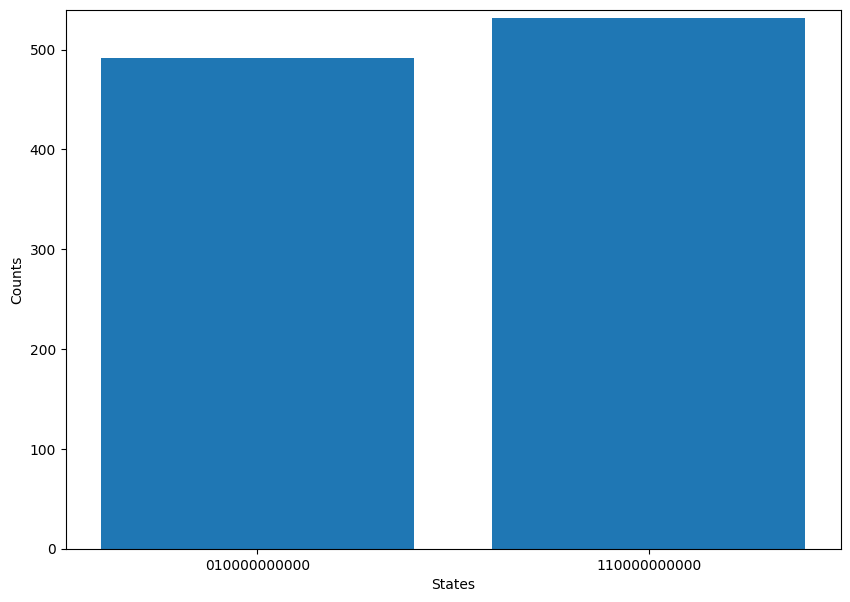

In [7]:
N = 3127  # Example number to factor

# Step 1: Choose a random number 'a'
a = random.randint(2, N-1)

qc = shors_algorithm(N,a)

# Execute the circuit
job = backend.run(qc, shots=shots)
job_monitor(job)
result = job.result()
counts = result.get_counts()

# visualize
plot_histogram(counts)

#clean up
#del q, c, qc
#del result
#del job

In [8]:
from fractions import Fraction

def continued_fraction_expansion(measured_value, num_qubits):
    """Find the period r using continued fraction expansion."""
    # Compute the estimated fraction s/r from the measured value
    s = measured_value / (2 ** num_qubits)
    
    # Use continued fraction to find the denominator r
    fraction = Fraction(s).limit_denominator()
    r = fraction.denominator
    
    return r

def classical_post_processing(counts, a, N):
    """
    Processes quantum measurement results to find period r and compute factors of N.
    """
    num_qubits = int(np.ceil(np.log2(N)))
    
    for measured_str in counts:
        measured_value = int(measured_str[::-1], 2)  # Convert binary string to integer
        
        # Find the period r using continued fractions
        r = continued_fraction_expansion(measured_value, num_qubits)
        
        if r % 2 != 0:  # We need r to be even
            continue
        
        # Compute potential factors
        factor1 = gcd(a**(r//2) - 1, N)
        factor2 = gcd(a**(r//2) + 1, N)

        if 1 < factor1 < N:
            return factor1, N // factor1  # Return the nontrivial factors
        
    return "Failed to find factors, try again."

# Example Usage:
#a = 7  # The chosen random number from quantum circuit
#N = 15  # The number we are factoring
#counts = {'0001': 400, '0010': 300, '0100': 200}  # Example simulated result

factors = classical_post_processing(counts, a, N)
print("Factors of", N, "are:", factors)

Factors of 3127 are: (53, 59)
